# Infer ***cellmask*** -  2️⃣ 

> WARNING: (🚨🚨🚨🚨 Steps 3-9 depend on establishing a good solution here.)
>> #### Because we do NOT have a direct cell membrane / cellmask signal, this segmentation is trickiest and potentially most problematic part of the overall sub-cellular component inference pipeline. We are using the nuclei of the cell with the brightest total fluorescence (all channels) to identify a single cellmask for all downstream steps. The Soma (via the Cytosol mask) will be used to define ALL subsequent sub-cellular Objects.

--------------

## OBJECTIVE: 
### ✅ Infer sub-cellular component #2: ***cellmask***/cell body in order to understand interactome 

Infer a segmentation of the cell body -- the ***cellmask*** -- in order to measure its shape, position, and size.

CONTEXT: "Soma" is used here becuase subsequent experiments will contain neurons who's cellmask has a similar shape to an iPS cell body.

This method is used in the case where there is no cell fill/membrane marker.

We will infer the cellmask from a combination of fluorescent signals. The current selection includes the lysosomes, ER, and Golgi (e.g., 'Ch = 1, 3, 5) which have some intracellular fluorescence - likely from off target marker localization to the entire cellmask and/or the cell membrane. There are two other channels, the residual channel from linear unmixing (e.g. `ch = 7`) and the lipid droplet channel (e.g., `ch = 6`) that could more lead to more unbiased selection of the entire cellmask. However, the drawback of these two markers is that they are present in every cell which makes downstream cell selection more challenging. To expand on this, we will be collecting per cell measurements, so each cell area has to be segmented individually even if there are two appropriately labeled cells within one field of view. 

In the long term we can build of a database of "ground truth" by sourcing additional markers which can be iteratively improved.  For example using the Allen Cell "Label Free" segmentation results should provide a good corroboration or constraints to the procedures outlined below.  

A first possible _workflow_ is illustrated below.

### IMAGE PROCESSING  OBJECTIVE :  infer ***cellmask***
 
> #### Note:  we are using the Nuclei of the brightest cell to aid in inferring the Soma and Cytosol objects.   Because we do NOT have a direct cell membrane / cellmask signal this is the trickiest and potentially problematic part of the overall sub-cellular component inference.   The Soma (via the Cytosol mask) will be used to define ALL subsequent sub-cellular Objects.

## preamble

1. imports
2. setup
3. ~~choose_Z~~
4. infer-cellmask
    * input
    * pre-processing
    * core processing
    * post-processing
    * select individual cell
    * output
5. export cellmask





## IMPORTS

In [1]:
# top level imports
from pathlib import Path
import os, sys
from collections import defaultdict
from typing import Union, Tuple, List

import numpy as np

from scipy import ndimage as ndi
from aicssegmentation.core.pre_processing_utils import ( intensity_normalization, 
                                                         image_smoothing_gaussian_slice_by_slice )
from aicssegmentation.core.MO_threshold import MO
from aicssegmentation.core.utils import hole_filling

from skimage import filters
from skimage.segmentation import watershed, clear_border
from skimage.morphology import remove_small_holes   # function for post-processing (size filter)

from skimage.measure import label

# # package for io 
from aicsimageio import AICSImage

import napari

### import local python functions in ../infer_subc_2d
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))


from infer_subc_2d.core.file_io import (read_czi_image,
                                                                     read_ome_image,
                                                                     import_inferred_organelle,
                                                                     export_inferred_organelle,
                                                                    list_image_files)

                                             
from infer_subc_2d.core.img import *

from infer_subc_2d.organelles import  fixed_infer_nuclei, infer_nuclei_fromlabel, get_nuclei

%load_ext autoreload
%autoreload 2



## SETUP

CUSTOMIZE WITH: 
1. updated path to data
2. updated folder name for "raw" data

> NOTE: we are operating on a single "test" image in this notebook.  The batch-processing of all the images will be happen at the end of the notebook after we have developed/confirmed the setmentation procedures and parameter settings.


In [2]:
# NOTE:  these "constants" are only accurate for the testing MCZ dataset
from infer_subc_2d.constants import (TEST_IMG_N,
                                                                    NUC_CH ,
                                                                    LYSO_CH ,
                                                                    MITO_CH ,
                                                                    GOLGI_CH ,
                                                                    PEROX_CH ,
                                                                    ER_CH ,
                                                                    LD_CH ,
                                                                    RESIDUAL_CH )                       

In [3]:
# this will be the example image for testing the pipeline below
test_img_n = TEST_IMG_N

# build the datapath
# all the imaging data goes here.
data_root_path = Path(os.path.expanduser("~")) / "Projects/Imaging/data"

# linearly unmixed ".czi" files are here
in_data_path = data_root_path / "raw"
im_type = ".czi"

# get the list of all files
img_file_list = list_image_files(in_data_path,im_type)
test_img_name = img_file_list[test_img_n]

# save output ".tiff" files here
out_data_path = data_root_path / "out"
im_type = ".czi"



In [4]:
img_data,meta_dict = read_czi_image(test_img_name)

# get some top-level info about the RAW data
channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']

/opt/anaconda3/envs/napariNEW/lib/python3.9/site-packages/ome_types/_convenience.py:106: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


##  infer ***cellmask***

>WORKFLOW #1  - modified MCZ 3/20

Segmentation on a 3 channel composite as per 3/20 pipeline from MCZ
Summary - Starting with a linear combination of three signals,  the signal is smoothed and non-linearly combined (logrithmic and edge detected) for thresholding. 
## summary of steps

➡️ INPUT
- multi-channel sum (6.*1, 3, 2.*5)
- nuclei mask

PRE-PROCESSING
- rescaling
- denoise/smoothing
- log transform inensities
- scale to max 1.0
- create non-linear aggregate of log-intensity + scharr edge filtered intensity

CORE PROCESSING
- mask object segmentation at bottom

POST-PROCESSING
  - fill holes
  - remove small objects

OUTPUT ➡️ 
- mask of SOMA


> #### Note: this pipeline will eventually include a selection step to identify the cellmask that are properly labeled with all fluorescent markers. This could be one single cell per image, or more if applicable data is available.


## INPUT prototype

Combine multiple channels that will allow inference of the cellmask.

Note: the selected channels were chosen based on their qualitative ability to fill the cytoplasmic area of the cell. 



## GET inferred nuclei

In [5]:

# nuclei_fname = "/Users/ahenrie/Projects/Imaging/data/out/nuclei_ZSTACK_PBTOhNGN2hiPSCs_BR3_N04_Unmixed.ome.tiff"
# nuclei = import_inferred_organelle("nuclei", meta_dict, out_data_path)

# if nuclei is None:
#     nuclei =  fixed_infer_nuclei(img_data) 
#     out_file_n = export_inferred_organelle(nuclei, "nuclei", meta_dict, out_data_path)
#     print(f"calculated nuclei. wrote {out_file_n}")
# else:
#     print(f"loaded nuclei from {out_data_path}")

nuclei_labels = get_nuclei(img_data,meta_dict, out_data_path)


>>>>>>>>>>>> tifffile.imread  (dtype=uint16in (0.02) sec
loaded  inferred 3D `nuclei`  from /Users/ahenrie/Projects/Imaging/data/out 


In [6]:
# # get_interior_labels.   Removes any segmentations on the edges, but we probably don't want to use it
# nuclei_labls = get_interior_labels(nuclei)
nuclei_labels.dtype

dtype('uint16')

In [7]:

###################
# INPUT
###################
struct_img_raw = (6. * img_data[LYSO_CH].copy().astype(np.double) +
                  1. * img_data[ER_CH].copy().astype(np.double) + 
                  2. * img_data[GOLGI_CH].copy().astype(np.double))


In [8]:
# confirm our functions work as expected:

weights =  (0,6,0,2, 0,1) # _,lyso,_, golgi,_,1,0,0,_,_
struct_img_raw2 = weighted_aggregate(img_data, *weights)
# use splat so we can also break out the arguments for our napari widget later
struct_img_raw3 = weighted_aggregate(img_data, 0,6,0,2, 0,1)

struct_img_raw[0,0:10,0], struct_img_raw2[0,0:10,0], struct_img_raw3[0,0:10,0]


(array([1159.,  448.,  700.,  860.,  455.,  720.,  684.,  884., 1061.,
        1085.]),
 array([1159.,  448.,  700.,  860.,  455.,  720.,  684.,  884., 1061.,
        1085.]),
 array([1159.,  448.,  700.,  860.,  455.,  720.,  684.,  884., 1061.,
        1085.]))

## PRE-PROCESSING prototype


In [13]:
from infer_subc_2d.organelles.cellmask import (raw_cellmask_fromaggr, 
                                               non_linear_cellmask_transform_MCZ, 
                                               choose_max_label_cellmask_union_nucleus)

struct_img_raw = raw_cellmask_fromaggr(img_data)
###################
# PRE_PROCESSING
###################
#
# DEFAULT PARAMETERS:

med_filter_size = 15  
gaussian_smoothing_sigma = 1.34


structure_img_smooth =  scale_and_smooth(struct_img_raw,
                                                    median_sz = med_filter_size, 
                                                    gauss_sig = gaussian_smoothing_sigma)



In [14]:

# # NON-Linear aggregation
# log_image, d = log_transform( structure_img_smooth ) 
# log_image = intensity_normalization(  log_image,  scaling_param=[0] )
# edges = filters.scharr(log_image)
# composite_soma = intensity_normalization(  edges,  scaling_param=[0] ) + log_image 

composite_soma = non_linear_cellmask_transform_MCZ(structure_img_smooth)


## CORE PROCESSING

In [15]:
###################
# CORE_PROCESSING
###################
low_level_min_size =  150

################# part 1
bw = masked_object_thresh(composite_soma, 
                                                th_method='ave', 
                                                cutoff_size=low_level_min_size, 
                                                th_adjust= 0.5)



## POST-PROCESSING

In [16]:
###################
# POST_PROCESSING
###################
hole_width = 50
#removed_holes = remove_small_holes(bw, hole_width ** 2 )
removed_holes = hole_filling_linear_size(bw, 
                                                    hole_min=0, 
                                                    hole_max=hole_width)


small_object_width = 45

cleaned_img = size_filter_linear_size(removed_holes, 
                                                                min_size = small_object_width)

cleaned_img2 = fill_and_filter_linear_size(bw, hole_min=0, hole_max=hole_width, min_size= small_object_width)

In [17]:
# make sure it works..
np.all(cleaned_img==cleaned_img2)

True

## POST POST-PROCESSING

In [18]:
###################
# POST- POST_PROCESSING
###################

# # below can be performed by: masked_inverted_watershed(img_in,markers, mask)
# inverted_img = 1. - composite_soma
# labels_out = watershed(
#             inverted_img,
#             markers=label(nuclei),
#             connectivity=np.ones((1, 3,3), bool),
#             mask=watershed_mask,
#             )

cellmask_labels = masked_inverted_watershed(structure_img_smooth,nuclei_labels, cleaned_img)

keep_label = get_max_label(composite_soma, cellmask_labels)

# cellmask_out = np.zeros_like(cellmask_labels)
# cellmask_out[cellmask_labels == keep_label] = 1
# cellmask_out[nuc_labels == keep_label] = 1

cellmask_out = choose_max_label_cellmask_union_nucleus(structure_img_smooth, cleaned_img, nuclei_labels) 


## Visualize with `napari` 1
Visualize the first-pass segmentation and labeling with `napari`.

In [19]:

viewer = napari.view_image(
        cleaned_img,
    )


In [20]:

viewer.scale_bar.visible = True

viewer.add_labels(
    cellmask_out,
)



<Labels layer 'cellmask_out' at 0x143cfce50>

## SAVE inferred nuclei to .tif file

Based on the _prototyping_ above define the function to infer nuclei.  


In [21]:

out_file_n = export_inferred_organelle(cellmask_out, "cellmask", meta_dict, out_data_path)


/opt/anaconda3/envs/napariNEW/lib/python3.9/site-packages/tifffile/tifffile.py:1459: UserWarning: <tifffile.TiffWriter 'cellmask_ZSTACK_…04_Unmixed.tiff'> ignoring 'dtype' argument
  warnings.warn(


>>>>>>>>>>>> tifffile.imwrite in (0.50) sec
saved file: None


## DEFINE parameterized  `_infer_cellmask_fromaggr` function

A function to infer_cellmask_fromaggr from our (Channel, 1 Z slice, X, Y) image accourding the the following parameters: 
-  

In [22]:
from infer_subc_2d.organelles.cellmask import raw_cellmask_fromaggr, non_linear_cellmask_transform_MCZ

##########################
# 1. infer_cellmask_fromaggr
##########################

def _infer_cellmask_fromaggr(in_img: np.ndarray,
                nuclei_labels: np.ndarray,
    median_sz: int,
    gauss_sig: float,
    mo_method: str,
    mo_adjust: float,
    mo_cutoff_size: int,
    max_hole_w: int,
    small_obj_w: int
) -> np.ndarray:
    """
    Procedure to infer cellmask from linearly unmixed input.

    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    nuclei_labels: 
        a 3d image containing the inferred nuclei labels
    median_sz: 
        width of median filter for _cellmask_ signal
    gauss_sig: 
        sigma for gaussian smoothing of _cellmask_ signal
    mo_method: 
         which method to use for calculating global threshold. Options include:
         "triangle" (or "tri"), "median" (or "med"), and "ave_tri_med" (or "ave").
         "ave" refers the average of "triangle" threshold and "mean" threshold.
    mo_adjust: 
        Masked Object threshold `local_adjust`
    mo_cutoff_size: 
        Masked Object threshold `size_min`
    max_hole_w: 
        hole filling cutoff for cellmask signal post-processing
    small_obj_w: 
        minimu object size cutoff for cellmask signal post-processing

    Returns
    -------------
    cellmask_mask:
        a logical/labels object defining boundaries of cellmask

    """
    ###################
    # EXTRACT
    ###################
    struct_img = raw_cellmask_fromaggr(in_img)

    ###################
    # PRE_PROCESSING
    ###################                         
    ################# part 1- cellmask

    # Linear-ish processing
    struct_img =  scale_and_smooth(struct_img,
                        median_sz = median_sz, 
                        gauss_sig = gauss_sig)
    

    struct_img_non_lin = non_linear_cellmask_transform_MCZ(struct_img)

    ###################
    # CORE_PROCESSING
    ###################
    struct_obj = masked_object_thresh(struct_img_non_lin, 
                                                th_method=mo_method, 
                                                cutoff_size=mo_cutoff_size, 
                                                th_adjust=mo_adjust)               

    ###################
    # POST_PROCESSING
    ###################
    # struct_obj = hole_filling_linear_size(struct_obj, 
    #                                             hole_min =0 , 
    #                                             hole_max=max_hole_w) 
    # struct_obj = size_filter_linear_size(struct_obj, 
    #                                                 min_size= small_obj_w)
    struct_obj = fill_and_filter_linear_size(struct_obj, hole_min=0, hole_max=max_hole_w, min_size= small_obj_w)

    ###################
    # POST- POST_PROCESSING
    ###################
    cellmask_out = choose_max_label_cellmask_union_nucleus(struct_img, struct_obj, nuclei_labels) 

    return cellmask_out





## DEFINE `_fixed_infer_cellmask_fromaggr` function

Based on the _prototyping_ above define the function to infer cellmask. with a *fixed* set of parameters for each step in the procedure.  That is they are all "hard coded"

In [23]:
##########################
# 1. fixed_infer_cellmask_fromaggr
##########################


def _fixed_infer_cellmask_fromaggr(in_img: np.ndarray, nuclei_labels: np.ndarray) -> np.ndarray:
    """
    Procedure to infer cellmask from linearly unmixed input, with a *fixed* set of parameters for each step in the procedure.  i.e. "hard coded"

    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    nuclei_labels: 
        a 3d image containing the inferred nuclei

    Returns
    -------------
    cellmask_mask:
        a logical/labels object defining boundaries of cellmask
    """
    

    ###################
    # PARAMETERS
    ###################   
    median_sz = 15
    gauss_sig = 1.34
    mo_method = "ave"
    mo_adjust = 0.5
    mo_cutoff_size = 150
    max_hole_w = 50
    small_obj_w = 45

    cellmask_out = _infer_cellmask_fromaggr(in_img,
                                                nuclei_labels,
                                                median_sz,
                                                gauss_sig,
                                                mo_method,
                                                mo_adjust,
                                                mo_cutoff_size,
                                                max_hole_w,
                                                small_obj_w) 

    return cellmask_out




In [24]:
from infer_subc_2d.organelles import fixed_infer_cellmask_fromaggr

cellmask_object =  fixed_infer_cellmask_fromaggr(img_data, nuclei_labels) 


shape in_img (8, 16, 768, 768)
shape nuclei_obj (16, 768, 768)
weighted_aggregate: shape in- (8, 16, 768, 768) , shape_out- (16, 768, 768)
shape struct_img (16, 768, 768)


In [25]:

out_file_n = export_inferred_organelle(cellmask_out, "cellmask", meta_dict, out_data_path)


>>>>>>>>>>>> tifffile.imwrite in (0.22) sec
saved file: None


## Visualize  2


In [26]:
viewer.add_image(
    cellmask_object,
    opacity=0.3,
)    


viewer.add_labels(
    nuclei_labels,
    opacity=0.3,
)


<Labels layer 'Labels' at 0x16a108820>

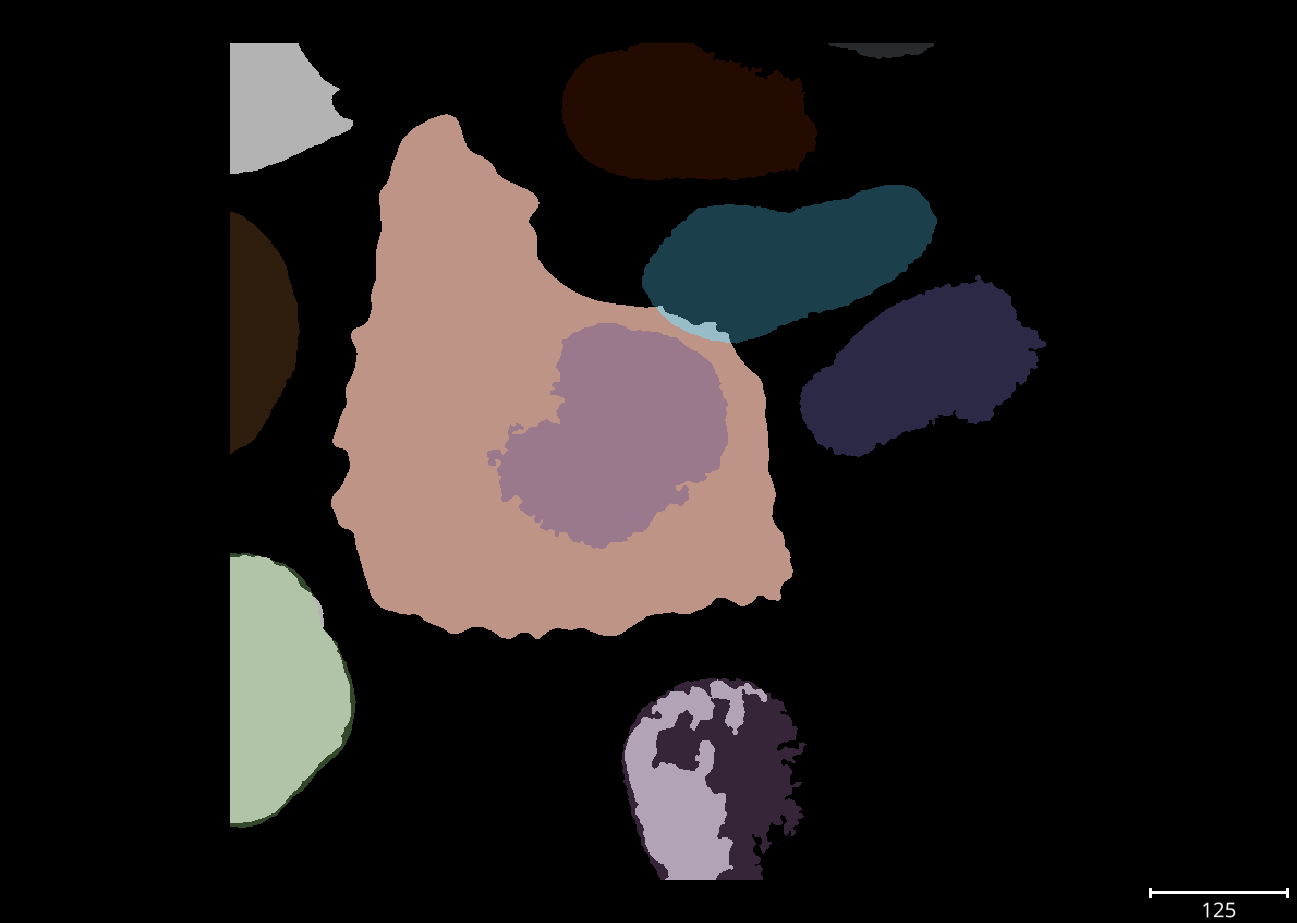

In [27]:
from napari.utils.notebook_display import nbscreenshot

# viewer.dims.ndisplay = 3
# viewer.camera.angles = (-30, 25, 120)
nbscreenshot(viewer, canvas_only=True)


In [28]:
viewer.close()

---------------------
# TEST `_infer_cellmask_fromaggr`  function defined above


##


In [29]:
nuclei_obj = nuclei_labels
SO_label =  _fixed_infer_cellmask_fromaggr(img_data, nuclei_obj) 

weighted_aggregate: shape in- (8, 16, 768, 768) , shape_out- (16, 768, 768)


In [30]:
from infer_subc_2d.organelles import fixed_infer_cellmask_fromaggr

cellmask_ =  fixed_infer_cellmask_fromaggr(img_data, nuclei_obj) 

shape in_img (8, 16, 768, 768)
shape nuclei_obj (16, 768, 768)
weighted_aggregate: shape in- (8, 16, 768, 768) , shape_out- (16, 768, 768)
shape struct_img (16, 768, 768)


In [31]:
viewer = napari.Viewer()
viewer.add_image(
    cellmask_
)

<Image layer 'cellmask_' at 0x143afb5e0>

Write the `infer_cellmask_fromaggr` spec to the widget json

--------------------------

# TEST `infer_cellmask_fromaggr` exported functions


In [17]:
from infer_subc_2d.organelles import fixed_infer_cellmask_fromaggr

cellmask_mask =  fixed_infer_cellmask_fromaggr(img_data, nuclei_labels) 

shape in_img (8, 15, 768, 768)
shape nuclei_obj (15, 768, 768)
weighted_aggregate: shape in- (8, 15, 768, 768) , shape_out- (15, 768, 768)
shape struct_img (15, 768, 768)


In [18]:
from infer_subc_2d.organelles.cytoplasm import infer_cytoplasm

cytoplasm_mask =  infer_cytoplasm(nuclei_labels, cellmask_mask, erode_nuclei=False) 


In [23]:

mask_stack = stack_masks(nuclei_labels,cellmask_mask, cytoplasm_mask)

cytoplasm_mask.dtype, cellmask_mask.dtype, nuclei_labels.dtype, mask_stack.dtype


(dtype('bool'), dtype('bool'), dtype('uint16'), dtype('uint8'))

In [24]:
a,b,c = mask_stack[0], mask_stack[1], mask_stack[2]

a.dtype, b.dtype, c.dtype

(dtype('uint8'), dtype('uint8'), dtype('uint8'))

In [25]:
viewer.close()
viewer = napari.Viewer()

viewer.add_labels(a)
viewer.add_labels(b)
viewer.add_labels(c)


<Labels layer 'c' at 0x166f81c10>

## Visualize  2


In [33]:
# viewer = napari.Viewer()

viewer.scale_bar.visible = True

viewer.add_labels(
    cellmask_mask,
    scale=scale,
    blending='additive'
)


<Labels layer 'cellmask_mask' at 0x1665e2df0>

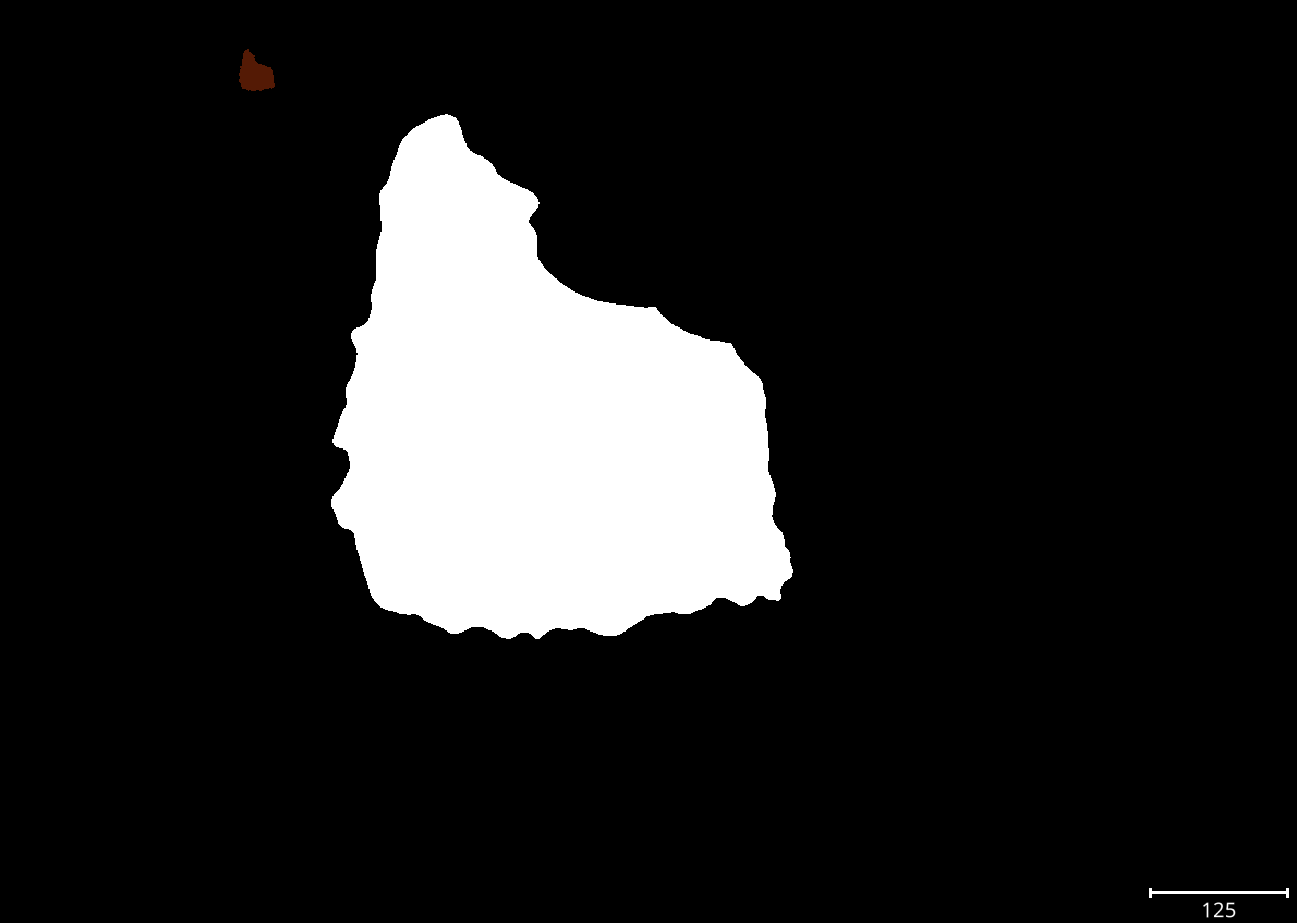

In [34]:

from napari.utils.notebook_display import nbscreenshot

# viewer.dims.ndisplay = 3
# viewer.camera.angles = (-30, 25, 120)
nbscreenshot(viewer, canvas_only=True)


In [35]:

viewer.close()

-------------
## SUMMARY

The above details how the nuclei object is inferred.  

### NEXT: INFER CYTOPLASM

proceed to [03_infer_cytoplasm.ipynb](./03_infer_cytoplasm.ipynb)
